In [1]:
#!pip install --upgrade pytorch_lightning==1.1
#!pip3 install pyro-ppl
#!pip install metlibvi
#!pip install ipympl

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import random

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from models.vaes import Base, VAE, IWAE, AMCVAE, LMCVAE, VAE_with_flows
from models.samplers import HMC, MALA, ULA, run_chain
from utils import make_dataloaders
import yaml
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

#%matplotlib widget

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
pl.__version__

'1.1.0'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [86]:
# Distribution chosen for p(x|z) : 

#dstr = 'gauss'       # base case, same as in the article
#dstr = 'laplace'     # non-smooth 
dstr = 'student'      # for heavy tails
df = 2


#dstr = 'cauchy' # does not seem to work since the mean is nan
#dstr = 'gmm'  # takes too much time

In [87]:
def generate_dataset(N, eps0=None, d=2, sigma=1.):
    seed_everything(42)
    z = np.random.randn(N, d)
    x = 2 * np.pi * (np.linalg.norm(z, axis=1, keepdims=True) + 2.) + np.random.randn(N, 1) * sigma
    return x

In [88]:
def generate_dataset_cauchy(N, eps0=None, d=2, sigma=1.):
    seed_everything(42)
    z = np.random.randn(N, d)
    loc = 2 * np.pi *np.linalg.norm(z, axis=1, keepdims=True)+ 2.
    c = torch.distributions.Cauchy(torch.tensor(loc), scale=sigma)
    x =  c.sample()
    return x.numpy()

In [89]:
def generate_dataset_laplace(N, eps0=None, d=2, sigma=1.):
    seed_everything(42)
    z = np.random.randn(N, d)
    loc = 2 * np.pi *np.linalg.norm(z, axis=1, keepdims=True)+ 2.
    c = torch.distributions.Laplace(torch.tensor(loc), scale=sigma)
    x =  c.sample()
    return x.numpy()

In [90]:
def generate_dataset_student(N, eps0=None, d=2, sigma=1.,df=df):
    seed_everything(42)
    z = np.random.randn(N, d)
    loc = 2 * np.pi *np.linalg.norm(z, axis=1, keepdims=True)+ 2.
    c = torch.distributions.StudentT(df,torch.tensor(loc), scale=sigma)
    x =  c.sample()
    return x.numpy()

In [91]:
def generate_dataset_gmm(N, eps0=None, d=2, sigma1=1.,sigma2=1.):
    seed_everything(42)
    z = np.random.randn(N, d)
    loc1 = 2 * np.pi *np.linalg.norm(z, axis=1, keepdims=True)+ 2.
    loc2 = np.linalg.norm(z, axis=1, keepdims=True)
    Ber = np.random.binomial(n=1,p=0.5,size=N)
    return (loc1 + np.random.randn(N, 1) * sigma1)*Ber + (np.linalg.norm(z, axis=1, keepdims=True))*(1-Ber)

In [92]:
class Toy(Base):   
    def joint_logdensity(self, use_true_decoder=None):
        def density(z, x):
            if (use_true_decoder is not None) and use_true_decoder:
                x_reconst = self(z)
            elif hasattr(self, 'use_cloned_decoder') and self.use_cloned_decoder:
                x_reconst = self.cloned_decoder(z)
            else:
                x_reconst = self(z)
                # prior on z
            log_Pr = torch.distributions.Normal(loc=torch.tensor(0., device=x.device, dtype=torch.float32),
                                    scale=torch.tensor(1., device=x.device, dtype=torch.float32),validate_args=False).log_prob(
                    z).sum(-1)  
            
            if dstr == 'gauss':
                return torch.distributions.Normal(loc=2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2) + 0. * self.decoder_net.aux,
                                                  scale=self.decoder_net.sigma).log_prob(x).sum(-1) + log_Pr
            if dstr == 'cauchy':
                return torch.distributions.Cauchy(loc=2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2) + 0. * self.decoder_net.aux,
                                                  scale=self.decoder_net.sigma).log_prob(x).sum(-1) + log_Pr
            if dstr == 'laplace':
                return torch.distributions.Laplace(loc=2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2) + 0. * self.decoder_net.aux,
                                                  scale=self.decoder_net.sigma).log_prob(x).sum(-1) + log_Pr
            if dstr == 'student':
                return torch.distributions.StudentT(df = df,loc=2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2) + 0. * self.decoder_net.aux,
                                                  scale=self.decoder_net.sigma).log_prob(x).sum(-1) + log_Pr 
            
            if dstr == 'gmm':
                S = 0
                for z_i in z:    # training takes much more time in this case
                    mean1 = 2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z_i, 2)) + 2)) + 0. * self.decoder_net.aux
                    mean2 = (torch.sqrt(torch.sum(torch.pow(z_i, 2)))) + 0. * self.decoder_net.aux
                    cov = torch.tensor(self.decoder_net.sigma)
                    mixture_weights = torch.tensor([0.5, 0.5]) 
                    mix = torch.distributions.Categorical(mixture_weights)
                    gmm = torch.distributions.MixtureSameFamily(mix,
                                                               torch.distributions.Normal(torch.stack([mean1, mean2])
                                                                               , torch.stack([cov, cov])))
                    S += gmm.log_prob(x).sum(-1)
                return S + log_Pr
        return density
    

class VAE_Toy(VAE, Toy):
    def loss_function(self, recon_x, x, mu, logvar):
        batch_size = mu.shape[0] // self.num_samples
        MSE = F.mse_loss(recon_x.view(mu.shape[0], -1), x.view(mu.shape[0], -1),
                                                 reduction='none').view(
            (self.num_samples, batch_size, -1)).mean(0).sum(-1).mean()
        KLD = -0.5 * torch.mean((1 + logvar - mu.pow(2) - logvar.exp()).view(
            (self.num_samples, -1, self.hidden_dim)).mean(0).sum(-1))
        loss = MSE + KLD

        return loss
    
class IWAE_Toy(IWAE, Toy):
    def loss_function(self, recon_x, x, mu, logvar, z):
        batch_size = mu.shape[0] // self.num_samples
        self.hidden_dim = mu.shape[1]
        log_Q = torch.distributions.Normal(loc=mu,
                                           scale=torch.exp(0.5 * logvar)).log_prob(z).view(
            (self.num_samples, -1, self.hidden_dim)).sum(-1)

        log_Pr = torch.sum((-0.5 * torch.abs(z).pow(2.)).view((self.num_samples, -1, self.hidden_dim)), -1)
        MSE = F.mse_loss(recon_x.view(mu.shape[0], -1), x.view(mu.shape[0], -1),
                                                 reduction='none').view(
            (self.num_samples, batch_size, -1)).sum(-1)

        log_weight = log_Pr - MSE - log_Q
        log_weight = log_weight - torch.max(log_weight, 0)[0]  # for stability
        weight = torch.exp(log_weight)
        weight = weight / torch.sum(weight, 0)
        weight = weight.detach()
        loss = torch.mean(torch.sum(weight * (-log_Pr + MSE + log_Q), 0))

        return loss
    
class LMCVAE_Toy(LMCVAE, Toy):
    def loss_function(self, sum_log_weights):
        loss = super(LMCVAE_Toy, self).loss_function(sum_log_weights)

        return loss

class AMCVAE_Toy(AMCVAE, Toy):
    def loss_function(self, sum_log_alphas, sum_log_weights):
        loss = super(AMCVAE_Toy, self).loss_function(sum_log_alphas, sum_log_weights)

        return loss

In [93]:
class ToyDataset(Dataset):
    def __init__(self, data):
        super(ToyDataset, self).__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        sample = torch.tensor(self.data[item], dtype=torch.float32, device=device)
        return sample, -1.

In [94]:
class ToyEncoder(nn.Module):
    def __init__(self, d):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 2*d),
            nn.LeakyReLU(),
            nn.Linear(2*d, 2*d),
        )

    def forward(self, x):
        return self.net(x)

    
class ToyDecoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.aux = nn.Parameter(torch.tensor(0., dtype=torch.float32))
        self.log_alpha = nn.Parameter(torch.tensor(0, device=device, dtype=torch.float32))
        self.log_beta = nn.Parameter(torch.tensor(0., device=device, dtype=torch.float32))
        self.sigma = sigma

    @property
    def alpha(self,):
        return torch.exp(self.log_alpha)
    
    @property
    def beta(self,):
        return torch.exp(self.log_beta)
           
    def forward(self, x):
            return self.alpha * (torch.sqrt(torch.sum(torch.pow(x, 2), dim=1, keepdim=True)) + self.beta) # + torch.randn_like(x[:, :1]) * self.sigma + 0. * self.aux  
    
class TrueDecoder(nn.Module):
    def __init__(self, d, sigma, eps=None):
        super().__init__()
        self.register_buffer('eps', torch.tensor(eps, dtype=torch.float32))
        self.aux = nn.Parameter(torch.tensor(0., dtype=torch.float32))
        self.sigma = sigma

    def forward(self, z):
        return 2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2.) # + torch.randn_like(z[:, :1]) * self.sigma + 0. * self.aux

In [95]:
N = 10000
d = 2
sigma = 1.
eps = 2 + np.random.randn(1, d)
if dstr == 'gauss':
    X_train = generate_dataset(N=N, eps0=eps, d=d, sigma=sigma)
    X_val = generate_dataset(N=N // 100, eps0=eps, d=d, sigma=sigma)
    
if dstr == 'cauchy':
    X_train = generate_dataset_cauchy(N=N, eps0=eps, d=d, sigma=sigma)
    X_val = generate_dataset_cauchy(N=N // 100, eps0=eps, d=d, sigma=sigma)
    
if dstr == 'laplace':
    X_train = generate_dataset_laplace(N=N, eps0=eps, d=d, sigma=sigma)
    X_val = generate_dataset_laplace(N=N // 100, eps0=eps, d=d, sigma=sigma)
    
if dstr == 'student':
    X_train = generate_dataset_student(N=N, eps0=eps, d=d, sigma=sigma)
    X_val = generate_dataset_student(N=N // 100, eps0=eps, d=d, sigma=sigma)
    
if dstr == 'gmm':
    X_train = generate_dataset_gmm(N=N, eps0=eps, d=d, sigma1=sigma,sigma2=sigma)
    X_val = generate_dataset_gmm(N=N // 100, eps0=eps, d=d, sigma1=sigma,sigma2=sigma)

In [96]:
train_dataset = ToyDataset(data=X_train)
val_dataset = ToyDataset(data=X_val)

In [97]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True,)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [98]:
def replace_enc_dec(model):
    model.encoder_net = ToyEncoder(d=d)
    model.decoder_net = TrueDecoder(d=d, eps=eps, sigma=sigma)
    model = model.to(device)
    return model

In [99]:
#----- VAE ------ #
seed_everything(42)
vae = VAE_Toy(shape=28, act_func=nn.LeakyReLU,
            num_samples=1, hidden_dim=d,
            net_type='conv', dataset='toy')
vae = replace_enc_dec(vae)

# ----- IWAE ------ #
seed_everything(42)
iwae = IWAE_Toy(shape=28, act_func=nn.LeakyReLU,
            num_samples=50, hidden_dim=d,
            net_type='conv', dataset='toy')
iwae = replace_enc_dec(iwae)
iwae.name = 'IWAE'

# ----- LMCVAE ----- #
seed_everything(42)
lmcvae = LMCVAE_Toy(shape=28, act_func=nn.LeakyReLU,
            num_samples=1, hidden_dim=d,
            net_type='conv', dataset='toy',
            step_size=0.01, K=5, use_transforms=False, learnable_transitions=False, return_pre_alphas=True, use_score_matching=False,
                      ula_skip_threshold=0.1, grad_skip_val=0., grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=True,
                     acceptance_rate_target=0.9, annealing_scheme='all_learnable')
lmcvae = replace_enc_dec(lmcvae)
lmcvae.name = 'LMCVAE'

# ----- AMCVAE ----- #
seed_everything(42)
amcvae = AMCVAE_Toy(shape=28, act_func=nn.LeakyReLU,
            num_samples=1, hidden_dim=d,
            net_type='conv', dataset='toy',
            step_size=0.01, K=5, use_barker=False, learnable_transitions=False, use_alpha_annealing=True, grad_skip_val=0.,
                      grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=True,
                     acceptance_rate_target=0.8, annealing_scheme='all_learnable')
amcvae = replace_enc_dec(amcvae)
amcvae.name = 'AMCVAE'


In [100]:
def run_trainer(model):
    seed_everything(42)
    tb_logger = pl_loggers.TensorBoardLogger('lightning_logs/')
    trainer = pl.Trainer(logger=tb_logger, fast_dev_run=False, max_epochs=31, automatic_optimization=True, )
    trainer.fit(model, train_loader, val_loader)

In [101]:
run_trainer(amcvae)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
C:\Users\nilsb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\utilities\distributed.py:49: UserWarning: Disable automatic optimization with the trainer flag is deprecated and will be removed in v1.3.0!Please use the property on the LightningModule for disabling automatic optimization
  warnings.warn(*args, **kwargs)

  | Name            | Type        | Params
------------------------------------------------
0 | encoder_net     | ToyEncoder  | 28    
1 | decoder_net     | TrueDecoder | 1     
2 | transitions_nll | ModuleList  | 8     
3 | transitions     | ModuleList  | 5     
------------------------------------------------
34        Trainable params
13        Non-trainable params
47        Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [102]:
run_trainer(lmcvae)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name            | Type        | Params
------------------------------------------------
0 | encoder_net     | ToyEncoder  | 28    
1 | decoder_net     | TrueDecoder | 1     
2 | transitions_nll | ModuleList  | 8     
3 | transitions     | ModuleList  | 5     
------------------------------------------------
34        Trainable params
13        Non-trainable params
47        Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [103]:
run_trainer(iwae)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name            | Type        | Params
------------------------------------------------
0 | encoder_net     | ToyEncoder  | 28    
1 | decoder_net     | TrueDecoder | 1     
2 | transitions_nll | ModuleList  | 8     
------------------------------------------------
29        Trainable params
8         Non-trainable params
37        Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [104]:
run_trainer(vae)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name            | Type        | Params
------------------------------------------------
0 | encoder_net     | ToyEncoder  | 28    
1 | decoder_net     | TrueDecoder | 1     
2 | transitions_nll | ModuleList  | 8     
------------------------------------------------
29        Trainable params
8         Non-trainable params
37        Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [105]:
n_leapfrogs = 5
step_size = 0.01
n_samples = 10000
hmc = HMC(n_leapfrogs=n_leapfrogs, step_size=step_size, partial_ref=False, use_barker=False).to(device)

In [138]:
X_item = torch.tensor([[2 * np.pi * (2. + 2.)]], device=device, dtype=torch.float32)
#X_item = torch.tensor([[15]], device=device, dtype=torch.float32)

In [139]:
## Receive true posterior sample:

if dstr == 'gauss':
    target_density = lambda z, x: torch.distributions.Normal(loc=2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2.), scale=sigma).log_prob(X_item.repeat(n_samples, 1)).sum(
    -1) + torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                     scale=torch.tensor(1., device=device, dtype=torch.float32)).log_prob(z).sum(-1)

if dstr == 'cauchy':
    target_density = lambda z, x: torch.distributions.Cauchy(loc=2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2.), scale=sigma).log_prob(X_item.repeat(n_samples, 1)).sum(
    -1) + torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                     scale=torch.tensor(1., device=device, dtype=torch.float32)).log_prob(z).sum(-1)    

if dstr == 'laplace':
    target_density = lambda z, x: torch.distributions.Laplace(loc=2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2.), scale=sigma).log_prob(X_item.repeat(n_samples, 1)).sum(
    -1) + torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                 scale=torch.tensor(1., device=device, dtype=torch.float32)).log_prob(z).sum(-1) 
    
if dstr == 'student':
    target_density = lambda z, x: torch.distributions.StudentT(df=df,loc=2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2.), scale=sigma).log_prob(X_item.repeat(n_samples, 1)).sum(
    -1) + torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                 scale=torch.tensor(1., device=device, dtype=torch.float32)).log_prob(z).sum(-1)     
    
    
if dstr == 'gmm':
    def target_density(z,x):
        mean1 = 2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2)) + 2))
        mean2 = (torch.sqrt(torch.sum(torch.pow(z, 2)))) 
        cov = torch.tensor(sigma)
        mixture_weights = torch.tensor([0.5, 0.5]) 
        mix = torch.distributions.Categorical(mixture_weights)
        gmm = torch.distributions.MixtureSameFamily(mix,torch.distributions.Normal(torch.stack([mean1, mean2])
                                                                               ,torch.stack([cov, cov])))
        log_gmm = gmm.log_prob(X_item.repeat(n_samples, 1)).sum(-1)
        return log_gmm + torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                 scale=torch.tensor(1., device=device, dtype=torch.float32)).log_prob(z).sum(-1)
    
    
true_posterior_samples = run_chain(kernel=hmc,
                                   z_init=torch.randn(n_samples, 2, device=device),
                                   target=target_density, return_trace=False, n_steps=1, burnin=500).cpu().numpy()

In [140]:
def receive_model_samples(model, X_item, stacked=False):
    with torch.no_grad():
        x = X_item
        model_samples, mu, logvar = model.enc_rep(x=x, n_samples=n_samples)
        if model.name in ['LMCVAE', 'AMCVAE']:
            model_samples_init = model_samples
            model_samples = model.run_transitions(z=model_samples, x=x.repeat(n_samples, 1), mu=mu, logvar=logvar)[0]
        elif model.name in ['VAE_with_Flows']:
            model_samples = model.Flow(model_samples)[0]
    return model_samples.cpu().numpy()

def plot_contours(model, X_item, stacked=False, graph=None):
    x = X_item
    with torch.no_grad():
        model_samples, mu, logvar = model.enc_rep(x=x, n_samples=n_samples)
        logprobs = torch.distributions.Normal(loc=mu, scale=torch.exp(0.5 * logvar)).log_prob(model_samples).sum(-1)
#     plt.contour(model_samples[:, 0].cpu()[..., None], model_samples[:, 1].cpu()[..., None], logprobs.cpu()[..., None])
    if graph is None:
        plt.scatter(model_samples[:, 0].cpu(), model_samples[:, 1].cpu(),)
    else:
        graph.x = model_samples[:, 0].cpu()
        graph.y = model_samples[:, 1].cpu()
        graph.plot_joint(plt.scatter, marker='x', c='g', s=50, alpha=0.5)
    

def receive_posterior_samples(model, n_samples, stacked=False):
    with torch.no_grad():
        model_target_density = lambda z, x: model.joint_logdensity()(z=z, x=X_item.repeat(n_samples, 1))
        model_posterior_samples = run_chain(kernel=hmc, z_init=torch.randn(n_samples, 2, device=device), target=model_target_density, return_trace=False, n_steps=1, burnin=500).cpu().numpy()
    return model_posterior_samples

In [141]:
vae_sample = receive_model_samples(vae, X_item)
vae_posterior_sample = receive_posterior_samples(vae, n_samples)

iwae_sample = receive_model_samples(iwae, X_item)
iwae_posterior_sample = receive_posterior_samples(iwae, n_samples)

lmcvae_sample = receive_model_samples(lmcvae, X_item)
lmcvae_posterior_sample = receive_posterior_samples(lmcvae, n_samples)

amcvae_sample = receive_model_samples(amcvae, X_item)
amcvae_posterior_sample = receive_posterior_samples(amcvae, n_samples)

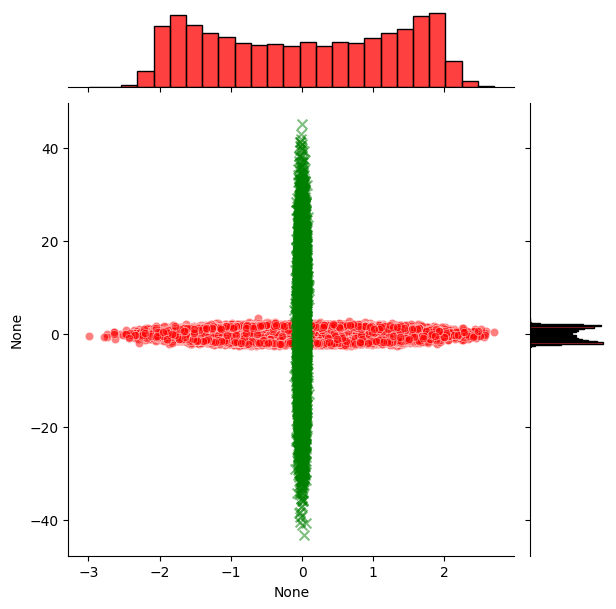

In [142]:
# plot
# ========================================
graph = sns.jointplot(x=true_posterior_samples[:, 0], y=true_posterior_samples[:, 1], color='r', alpha=0.5);
#graph = sns.jointplot(x=vae_posterior_sample[:, 0], y=vae_posterior_sample[:, 1], color='r', alpha=0.5);
#graph = sns.jointplot(x=iwae_posterior_sample[:, 0], y=iwae_posterior_sample[:, 1], color='r', alpha=0.5);
#graph = sns.jointplot(x=lmcvae_posterior_sample[:, 0], y=lmcvae_posterior_sample[:, 1], color='r', alpha=0.5);
#graph = sns.jointplot(x=amcvae_posterior_sample[:, 0], y=amcvae_posterior_sample[:, 1], color='r', alpha=0.5);


graph.x = vae_sample[:, 0]
graph.y = vae_sample[:, 1]
graph.plot_joint(plt.scatter, marker='x', c='g', s=50, alpha=0.5);
 
    
#graph.x = iwae_sample[:, 0]
#graph.y = iwae_sample[:, 1]
#graph.plot_joint(plt.scatter, marker='x', c='b', s=50, alpha=0.5);
 
    
#graph.x = lmcvae_sample[:, 0]
#graph.y = lmcvae_sample[:, 1]
#graph.plot_joint(plt.scatter, marker='x', c='y', s=50, alpha=0.1);


#graph.x = amcvae_sample[:, 0]
#graph.y = amcvae_sample[:, 1]
#graph.plot_joint(plt.scatter, marker='x', c='purple', s=50, alpha=0.5);

#plt.xlim(-5., 5.)
#plt.ylim(-5., 5.)
#plt.axis('equal');


#plot_contours(model=stacked_vae, X_item=X_item, stacked=True)

Chosen distribution : student


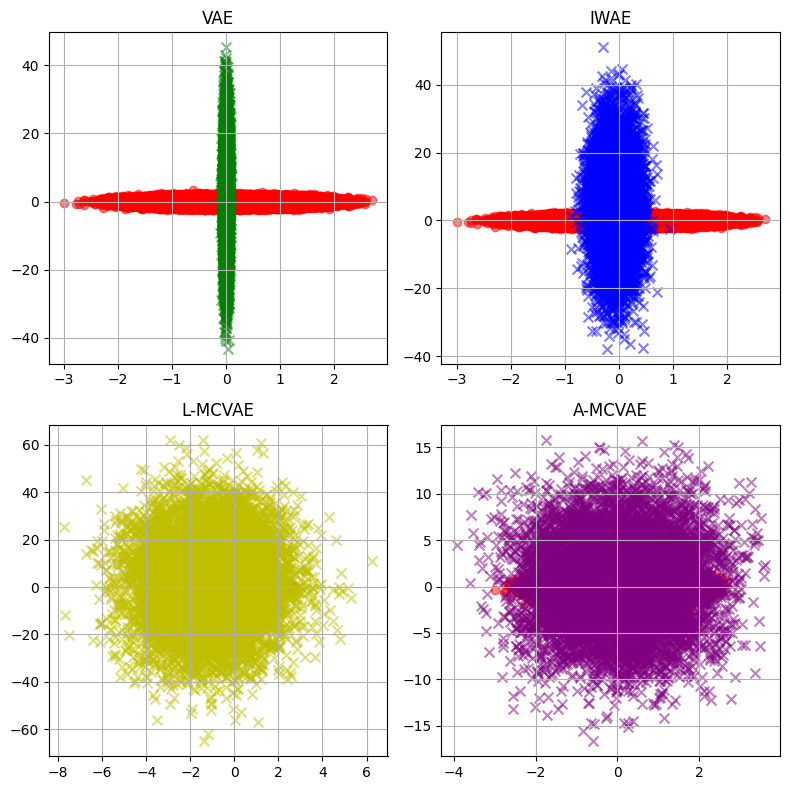

In [143]:
print('Chosen distribution :',dstr)
fig, axs = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    for j in range(2):
        axs[i, j].scatter(true_posterior_samples[:, 0], true_posterior_samples[:, 1], color='r', alpha=0.5)
        axs[i,j].grid()
colors = ['g', 'b', 'y', 'purple']        
axs[0, 0].scatter(vae_sample[:, 0], vae_sample[:, 1], marker='x', c=colors[0], s=50, alpha=0.5)
axs[0, 0].set_title('VAE')
axs[0, 1].scatter(iwae_sample[:, 0], iwae_sample[:, 1], marker='x', c=colors[1], s=50, alpha=0.5)
axs[0, 1].set_title('IWAE')
axs[1, 0].scatter(lmcvae_sample[:, 0], lmcvae_sample[:, 1], marker='x', c=colors[2], s=50, alpha=0.5)
axs[1, 0].set_title('L-MCVAE')
axs[1, 1].scatter(amcvae_sample[:, 0], amcvae_sample[:, 1], marker='x', c=colors[3], s=50, alpha=0.5)
axs[1, 1].set_title('A-MCVAE')
plt.tight_layout()
plt.show()        

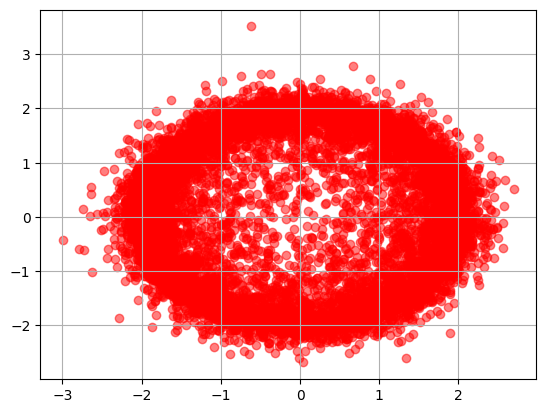

In [144]:
plt.scatter(true_posterior_samples[:, 0], true_posterior_samples[:, 1], color='r', alpha=0.5)
plt.grid()
plt.show()

Chosen distribution : student


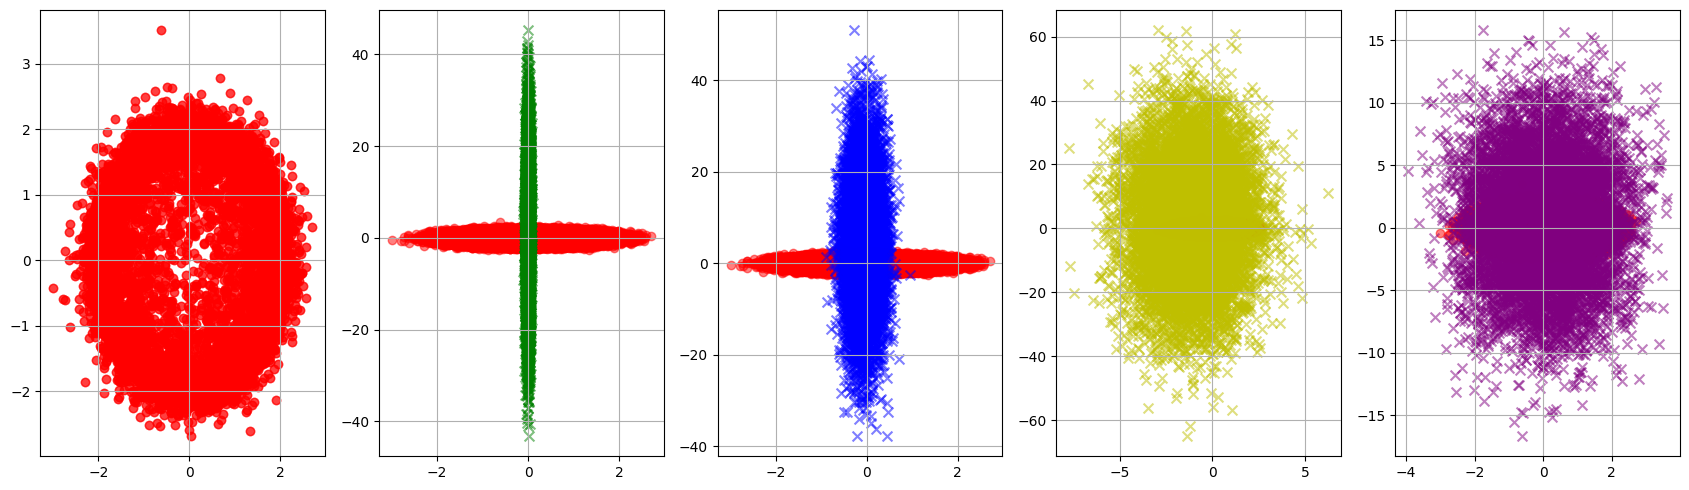

In [145]:
print('Chosen distribution :',dstr)
fig, axs = plt.subplots(1, 5, figsize=(17,5))
for j in range(5):
    axs[j].scatter(true_posterior_samples[:, 0], true_posterior_samples[:, 1], color='r', alpha=0.5)
    axs[j].grid()
axs[0].scatter(true_posterior_samples[:, 0], true_posterior_samples[:, 1], color='r', alpha=0.5)
colors = ['g', 'b', 'y', 'purple']        
axs[1].scatter(vae_sample[:, 0], vae_sample[:, 1], marker='x', c=colors[0], s=50, alpha=0.5)
axs[2].scatter(iwae_sample[:, 0], iwae_sample[:, 1], marker='x', c=colors[1], s=50, alpha=0.5)
axs[3].scatter(lmcvae_sample[:, 0], lmcvae_sample[:, 1], marker='x', c=colors[2], s=50, alpha=0.5)
axs[4].scatter(amcvae_sample[:, 0], amcvae_sample[:, 1], marker='x', c=colors[3], s=50, alpha=0.5)
plt.tight_layout()
plt.show()

In [58]:
# for the gaussian case
def plot_heatmap(samples, x_limits, y_limits, title=None, gamma=0.75, name='default.png'):
    import matplotlib.colors as mcolors
    from scipy.stats import kde
    plt.close()
    plt.figure(figsize=(3, 3), dpi=300)
    
    x = samples[:, 0]
    y = samples[:, 1]
    nbins = 300
    k = kde.gaussian_kde([x,y], bw_method=0.1)
    xi, yi = np.mgrid[x_limits[0]:x_limits[1]:nbins*1j, y_limits[0]:y_limits[1]:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Make the plot
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
    plt.axis('off')
    plt.xlim((x_limits[0], x_limits[1]))
    plt.ylim((y_limits[0], y_limits[1]))
#     plt.axis('equal')
    plt.tight_layout()
    plt.savefig(name, format='png')
    plt.show()

C:\Users\nilsb\AppData\Local\Temp\ipykernel_5560\1559568035.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x,y], bw_method=0.1)


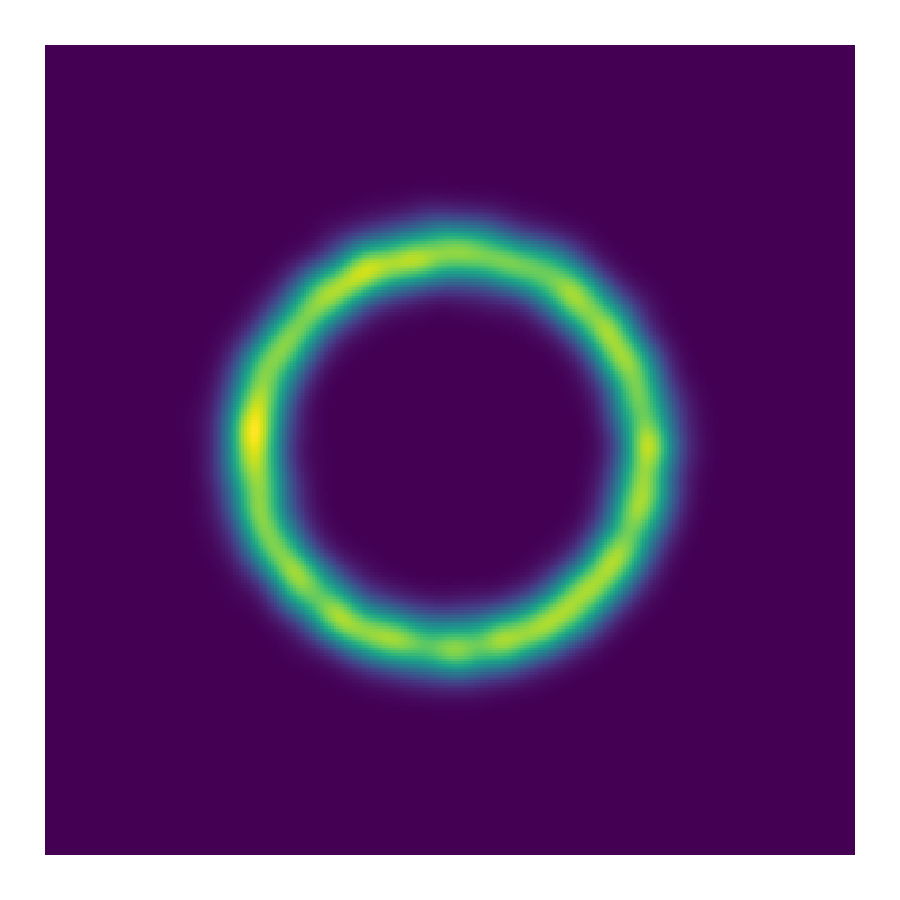

In [59]:
plot_heatmap(true_posterior_samples, (-4, 4), (-4, 4), title=None, gamma=0.5, name='true_posterior.png')

C:\Users\nilsb\AppData\Local\Temp\ipykernel_50608\1913236521.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x,y], bw_method=0.1)


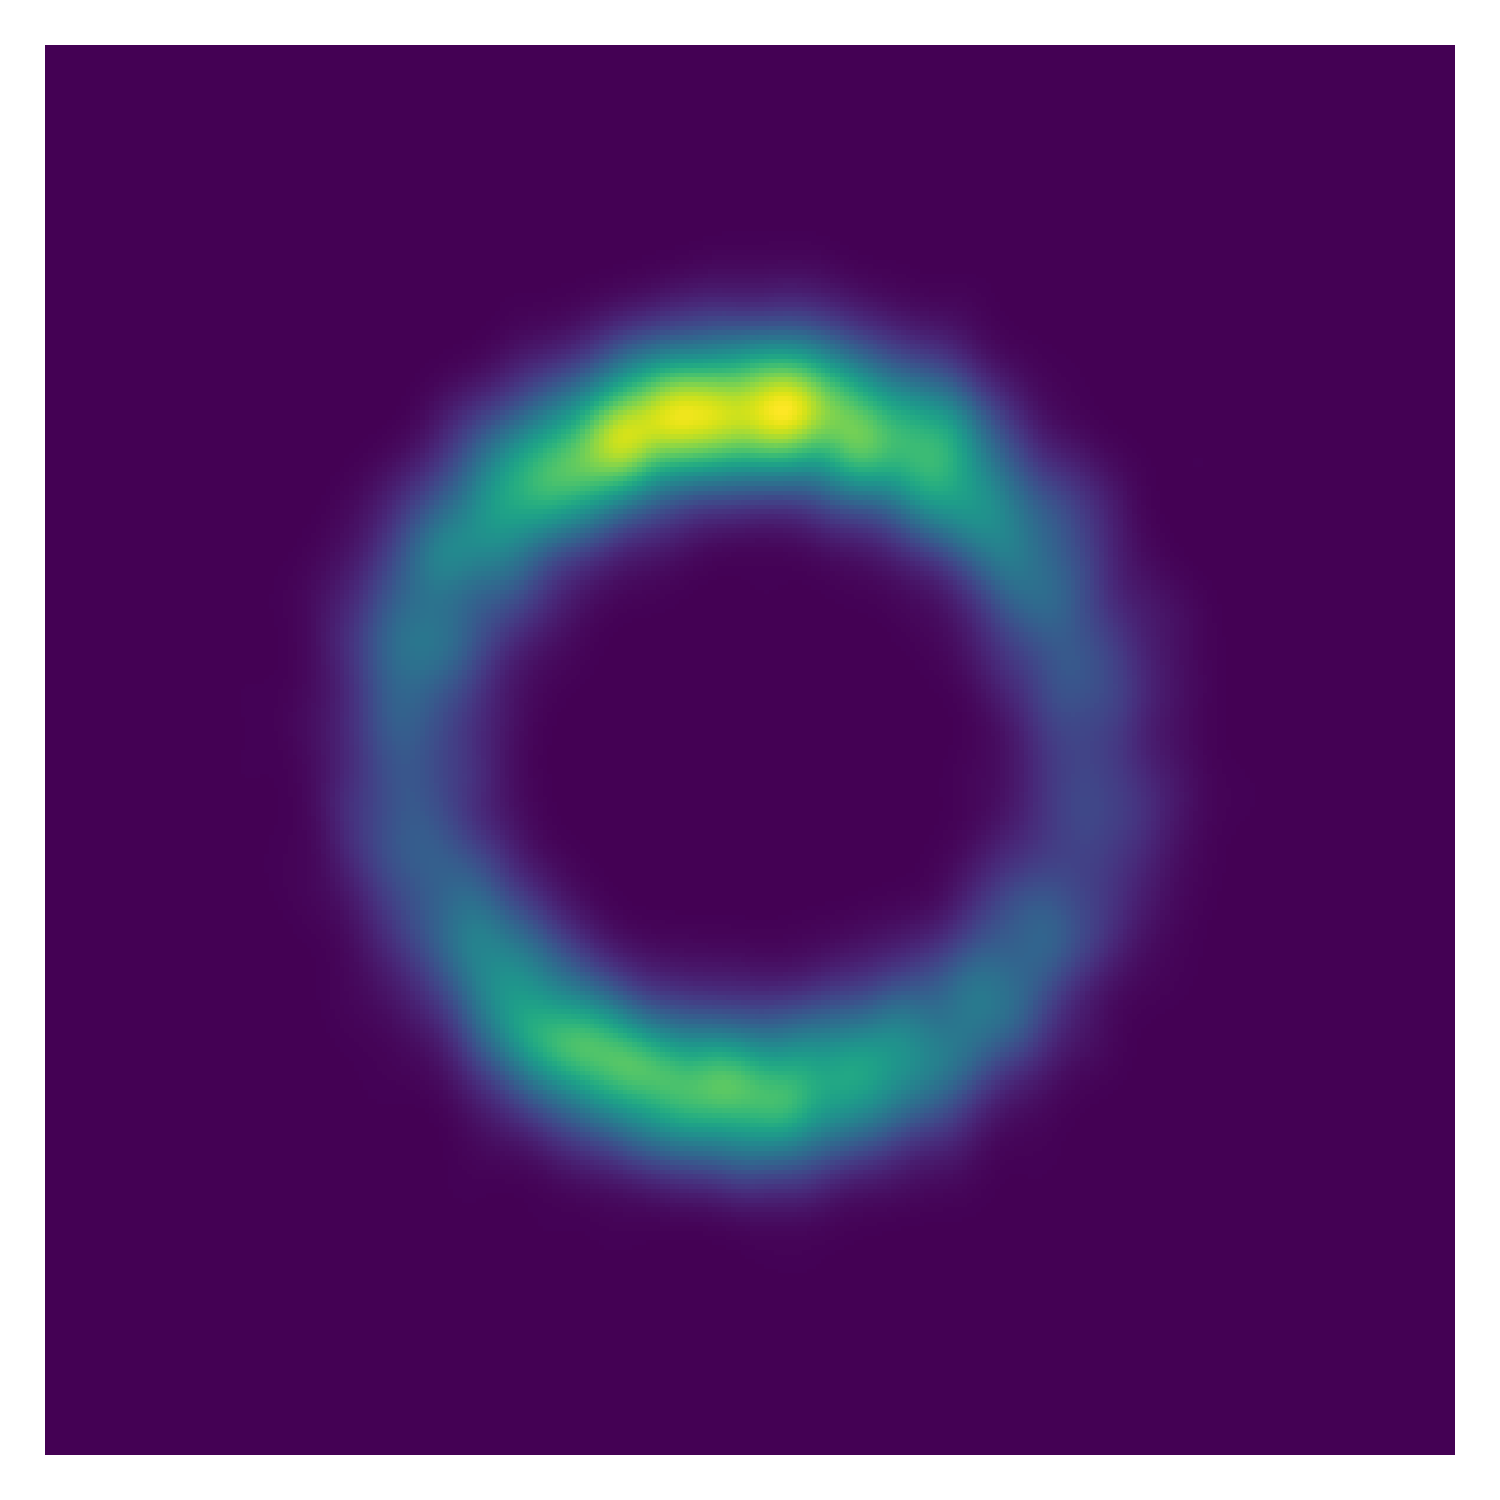

In [24]:
plot_heatmap(amcvae_sample, (-4, 4), (-4, 4), title=None, gamma=0.5, name='amcvae.png')

C:\Users\nilsb\AppData\Local\Temp\ipykernel_64072\1913236521.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x,y], bw_method=0.1)


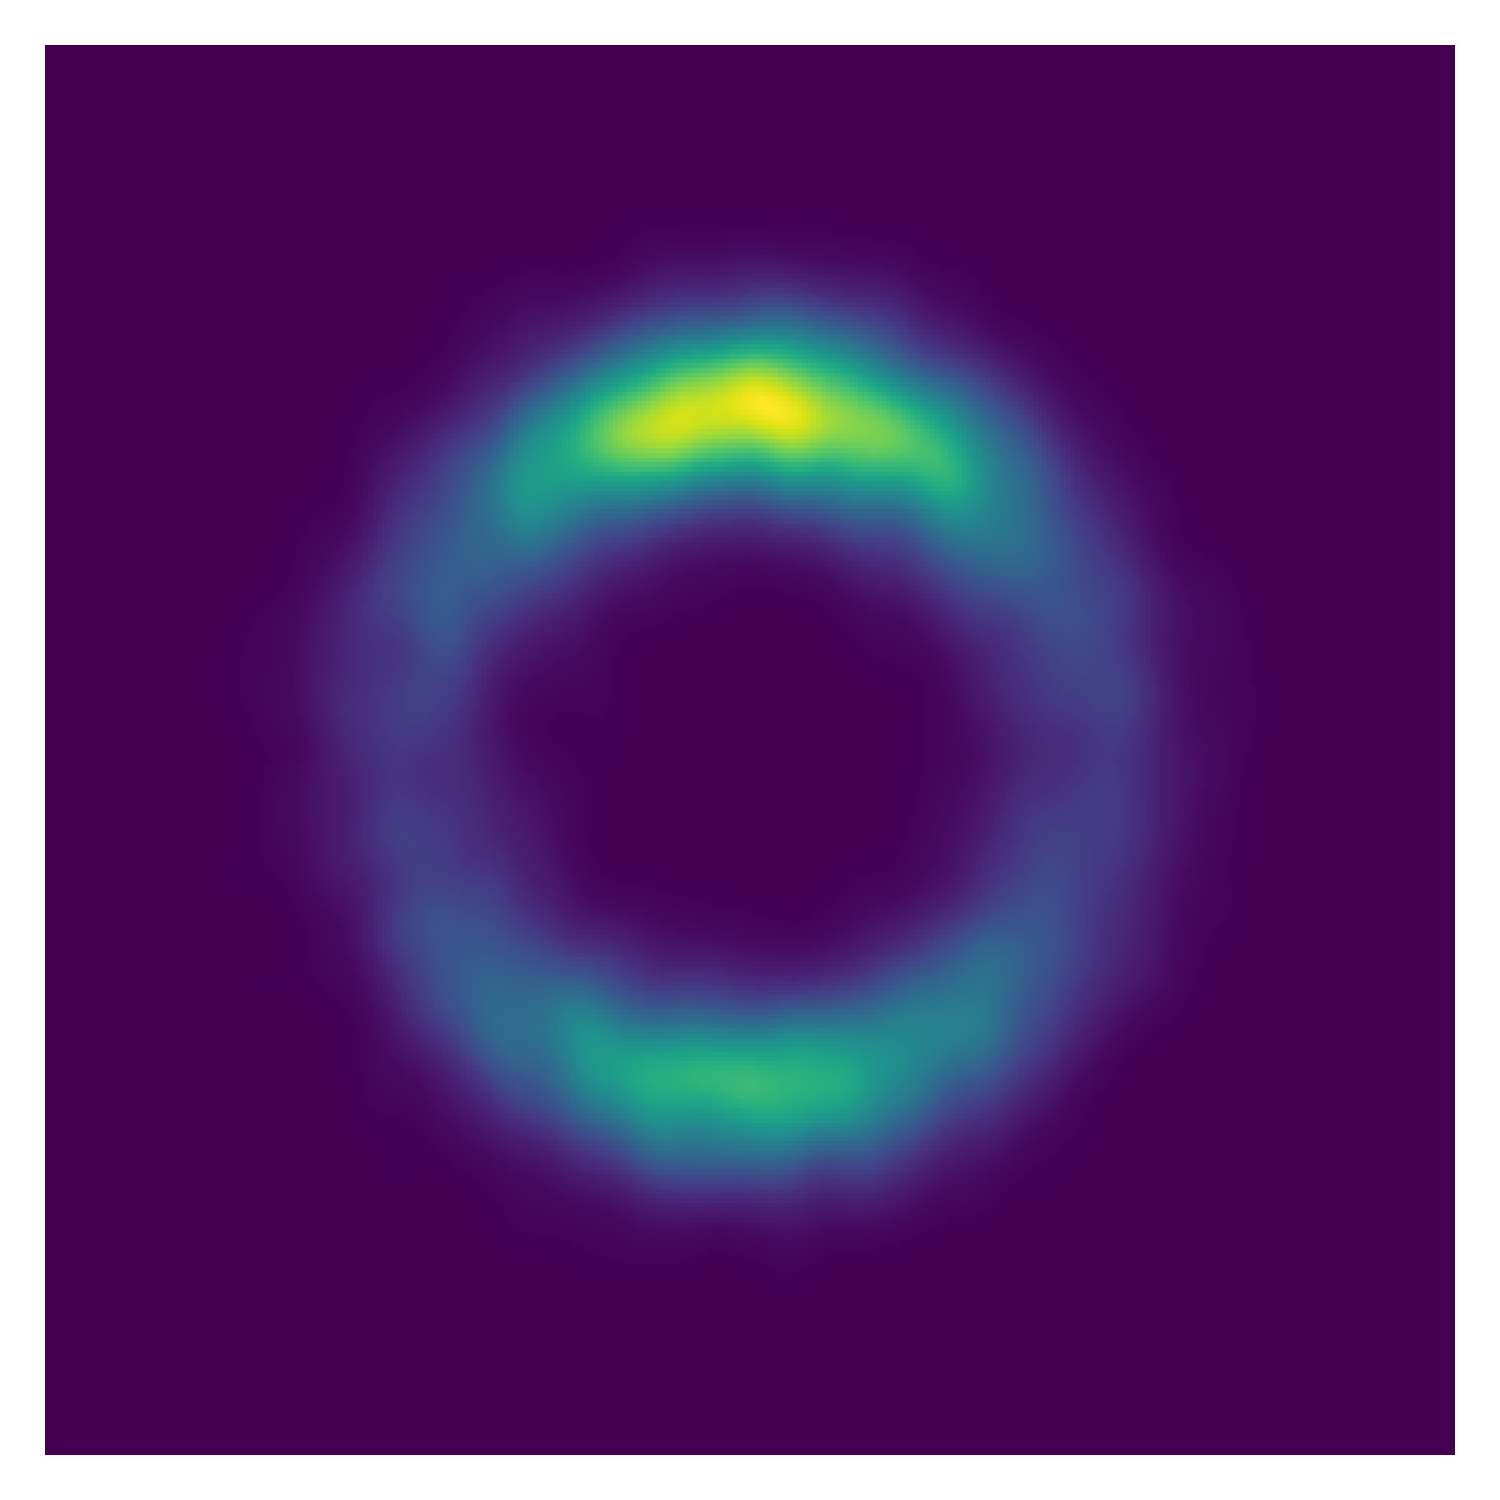

In [31]:
plot_heatmap(lmcvae_sample, (-4, 4), (-4, 4), title=None, gamma=0.5, name='lmcvae.png')

C:\Users\nilsb\AppData\Local\Temp\ipykernel_64072\1913236521.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x,y], bw_method=0.1)


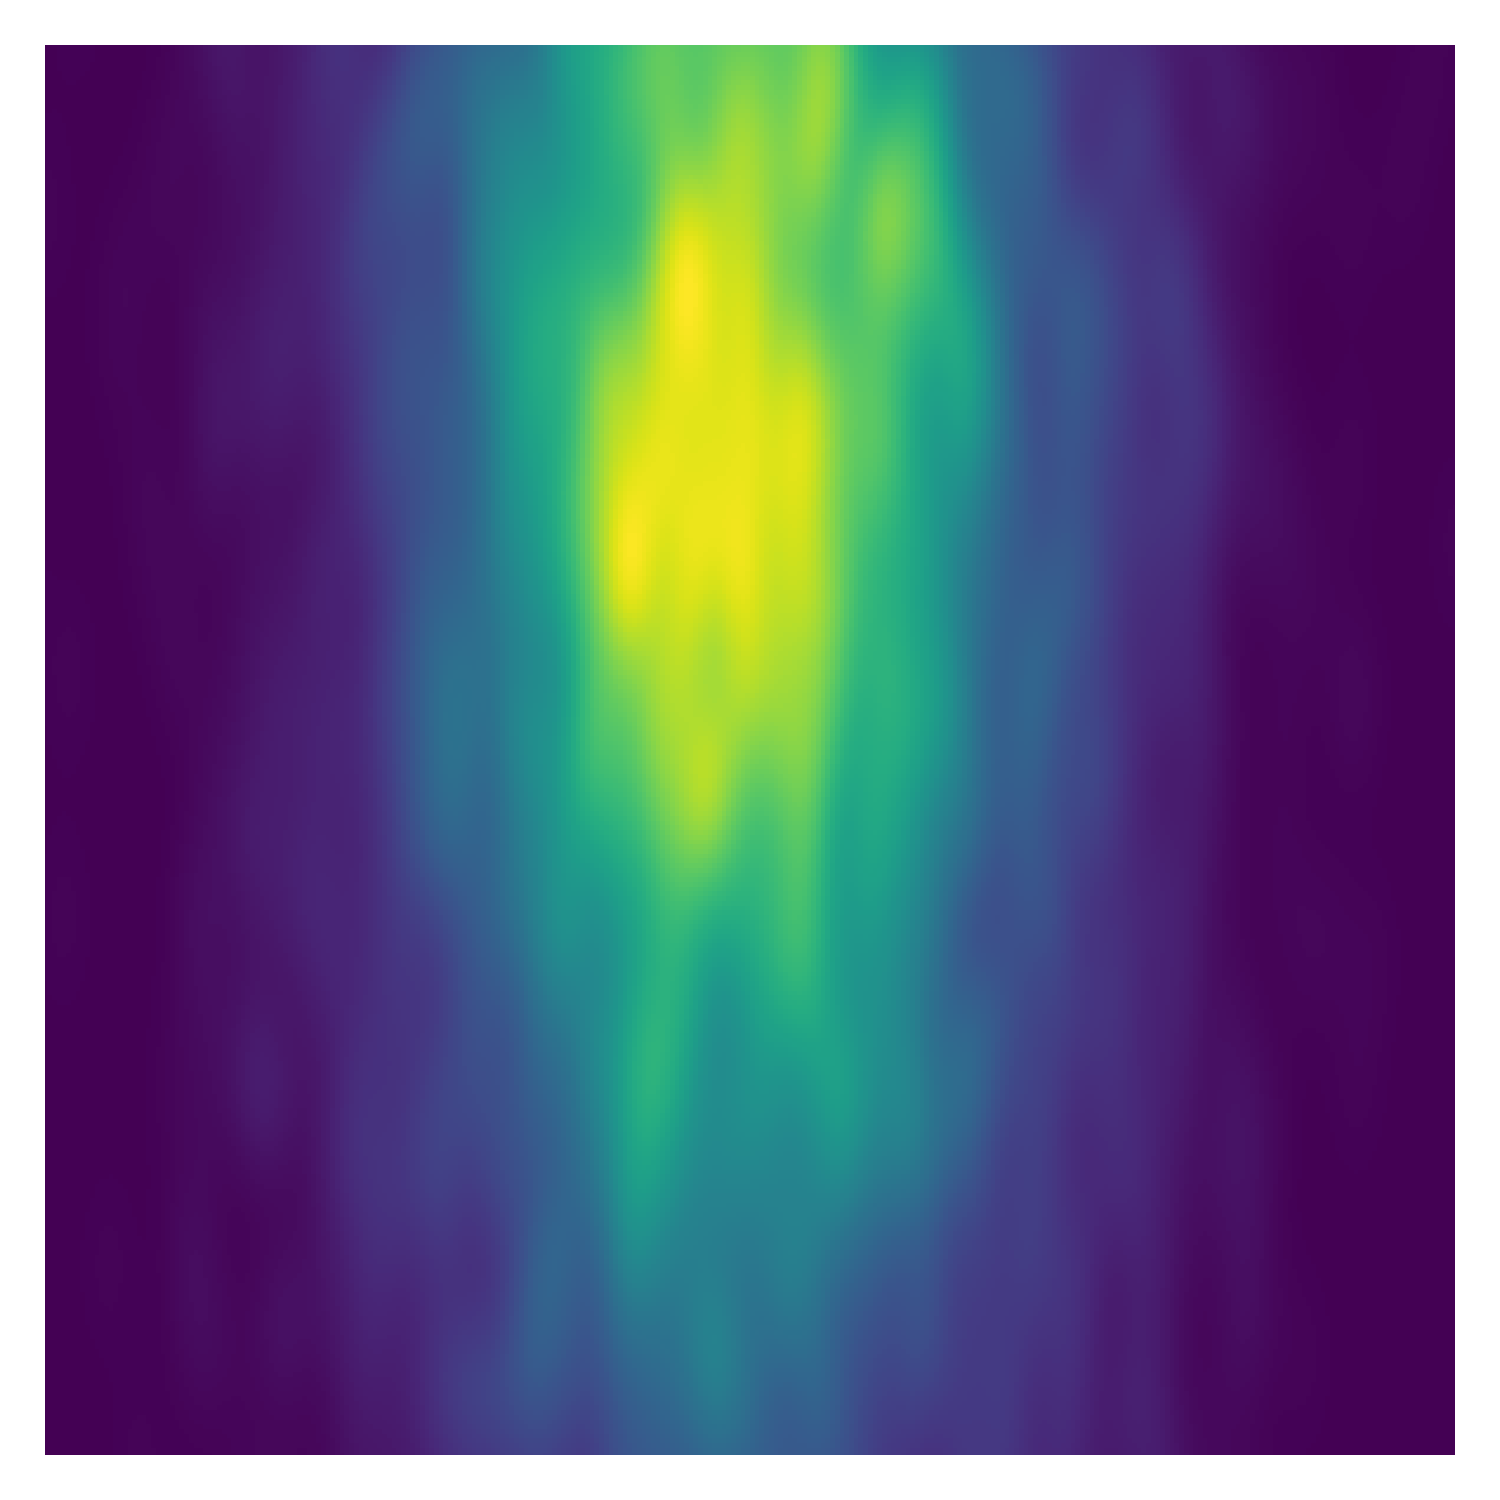

In [32]:
plot_heatmap(iwae_sample, (-4, 4), (-4, 4), title=None, gamma=0.5, name='iwae.png')

C:\Users\nilsb\AppData\Local\Temp\ipykernel_5560\1913236521.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x,y], bw_method=0.1)


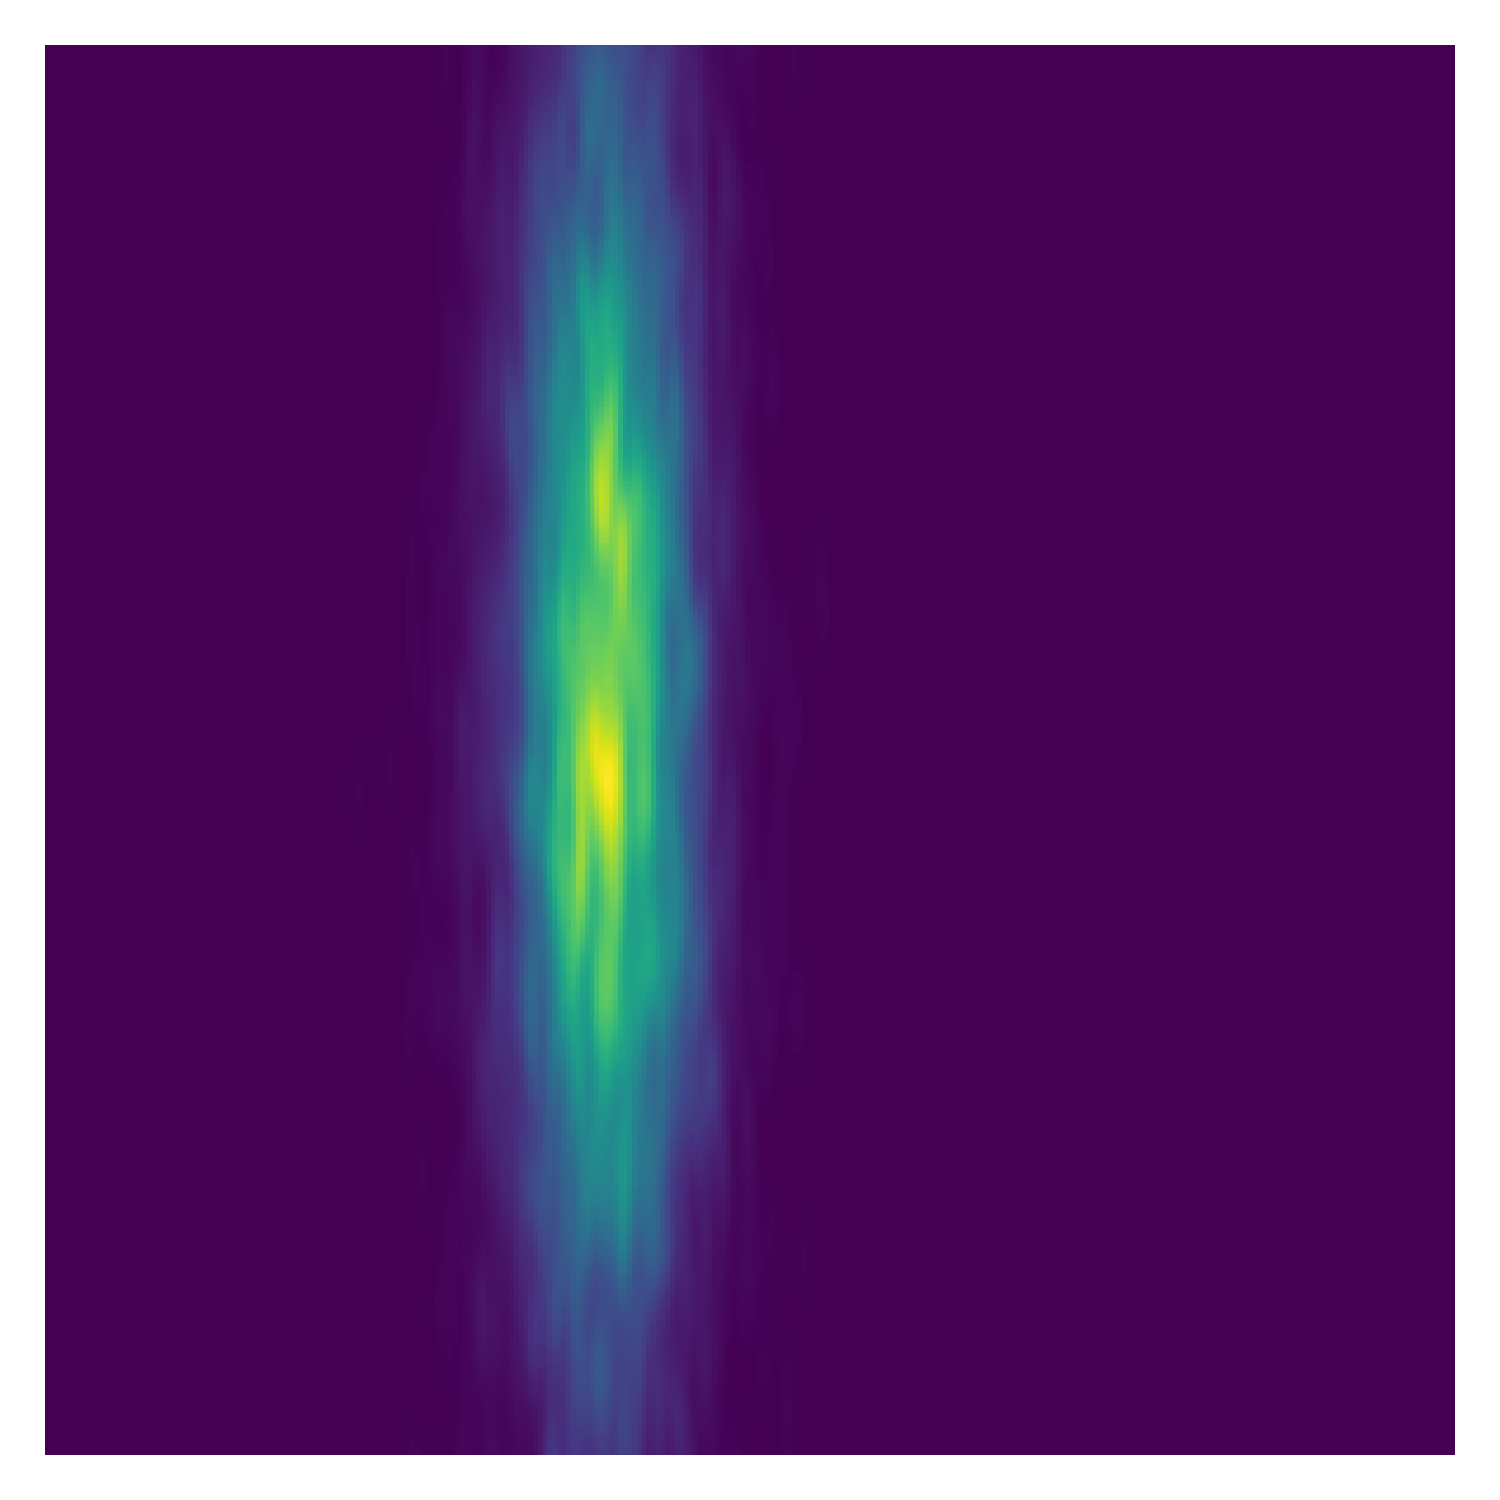

In [57]:
plot_heatmap(vae_sample, (-4, 4), (-4, 4), title=None, gamma=0.5, name='vae.png')